# Case 2: Siemens AI-Driven Sales Forecasting

## Overview
This case study involves building a monthly sales forecasting model using real sales data from Siemens’ Smart Infrastructure Division in Germany. The objective is to apply machine learning techniques to predict future sales based on historical data and macro-economic indicators.

## Business Problem
- Manual sales forecasting is time-consuming and relies on human judgment.  
- Data is scattered across multiple sources, making it difficult to derive insights.  
- Inaccurate forecasts lead to financial losses, such as inefficient inventory management and unsatisfied customers.

## Objective
- Develop an AI-driven predictive model to automate the forecasting process.  
- Evaluate the model using Root Mean Squared Error (RMSE).  
- Submit predictions for May 2022 - February 2023 in a structured CSV format.


---

**This notebook was developed by:**
- João Venichand - 20211644  
- Gonçalo Custódio - 20211643  
- Diogo Correia - 20211586  
- Duarte Emanuel - 20240564


### 1. Import the Libraries


In [376]:
# Standard libraries
import calendar
import warnings

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy.stats import zscore, boxcox
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Machine learning & forecasting
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from prophet import Prophet

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


### 2. Load Datasets

Import Sales Data

In [377]:
sales_data = pd.read_csv("Case2_Sales data.csv")
sales_data.head(5)

,DATE,Mapped_GCK,Sales_EUR
0,01.10.2018,#1,0
1,02.10.2018,#1,0
2,03.10.2018,#1,0
3,04.10.2018,#1,0
4,05.10.2018,#1,0


Import Market Data

In [378]:
market_data = pd.read_excel("Case2_Market data.xlsx", header=None)
market_data.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
0,NaN,China,China,France,France,Germany,Germany,Italy,Italy,Japan,Japan,Switzerland,Switzerland,United Kingdom,United Kingdom,United States,United States,Europe,Europe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Producer Prices,Producer Prices,Producer Prices,Producer Prices,Producer Prices,Producer Prices,production index,production index,production index,production index,production index,production index,production index,production index,production index,production index,production index,production index,production index,production index,production index,production index
1,Index 2010=100 (if not otherwise noted),Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,World: Price of Base Metals,World: Price of Energy,World: Price of Metals & Minerals,World: Price of Natural gas index,"World: Price of Crude oil, average",World: Price of Copper,United States: EUR in LCU,United States: Electrical equipment,United Kingdom: Electrical equipment,Italy: Electrical equipment,France: Electrical equipment,Germany: Electrical equipment,China: Electrical equipment,United States: Machinery and equipment n.e.c.,World: Machinery and equipment n.e.c.,Switzerland: Machinery and equipment n.e.c.,United Kingdom: Machinery and equipment n.e.c.,Italy: Machinery and equipment n.e.c.,Japan: Machinery and equipment n.e.c.,France: Machinery and equipment n.e.c.,Germany: Machinery and equipment n.e.c.,United States: Electrical equipment,World: Electrical equipment,Switzerland: Electrical equipment,United Kingdom: Electrical equipment,Italy: Electrical equipment,Japan: Electrical equipment,France: Electrical equipment,Germany: Electrical equipment
2,date,MAB_ELE_PRO156,MAB_ELE_SHP156,MAB_ELE_PRO250,MAB_ELE_SHP250,MAB_ELE_PRO276,MAB_ELE_SHP276,MAB_ELE_PRO380,MAB_ELE_SHP380,MAB_ELE_PRO392,MAB_ELE_SHP392,MAB_ELE_PRO756,MAB_ELE_SHP756,MAB_ELE_PRO826,MAB_ELE_SHP826,MAB_ELE_PRO840,MAB_ELE_SHP840,MAB_ELE_PRO1100,MAB_ELE_SHP1100,RohiBASEMET1000_org,RohiENERGY1000_org,RohiMETMIN1000_org,RohiNATGAS1000_org,RohCRUDE_PETRO1000_org,RohCOPPER1000_org,WKLWEUR840_org,PRI27840_org,PRI27826_org,PRI27380_org,PRI27250_org,PRI27276_org,PRI27156_org,PRO28840_org,PRO281000_org,PRO28756_org,PRO28826_org,PRO28380_org,PRO28392_org,PRO28250_org,PRO28276_org,PRO27840_org,PRO271000_org,PRO27756_org,PRO27826_org,PRO27380_org,PRO27392_org,PRO27250_org,PRO27276_org
3,2004m2,16.940704,16.940704,112.091273,83.458866,82.623037,79.452532,124.289603,86.560493,109.33401,110.495272,91.221862,89.987275,111.353812,73.601265,107.6014,79.24023,97.122911,80.09853,54.039811,44.123338,48.747945,87.076974,39.639458,36.623832,1.2646,78.969864,80.757423,93.020027,NaN,93.230453,NaN,102.491722,97.597374,97.1,106.191977,116.790276,110.890034,118.274109,80.82901,117.723991,NaN,81.1,120.706516,141.510864,106.161262,102.077057,85.9132
4,2004m3,23.711852,23.711852,136.327976,106.168192,100.556582,97.012918,143.411662,106.344544,140.884616,144.686166,85.866287,79.883583,127.558608,84.047595,110.187364,98.619024,113.783904,96.015929,54.666162,47.588957,49.256157,87.192705,42.592034,39.931055,1.2262,79.673569,80.962135,93.540268,NaN,93.335678,NaN,105.62748,113.224892,91.195116,121.625075,139.288391,141.176853,148.121841,102.130104,1

### 3. Sales Dataset Analysis

Check for missing values

In [381]:
missing_values = sales_data["Sales_EUR"].isna().sum()

missing_values

0

Count occurrences of 0 and non-zero Sales

In [382]:
zero_count = (sales_data["Sales_EUR"] == 0).sum()
non_zero_count = (sales_data["Sales_EUR"] != 0).sum()

print(f"Zero Sales Count: {zero_count}")
print(f"Non-Zero Sales Count: {non_zero_count}")

Zero Sales Count: 7135
Non-Zero Sales Count: 2667


Sales Distribution by Product (excluding 0 sales values)

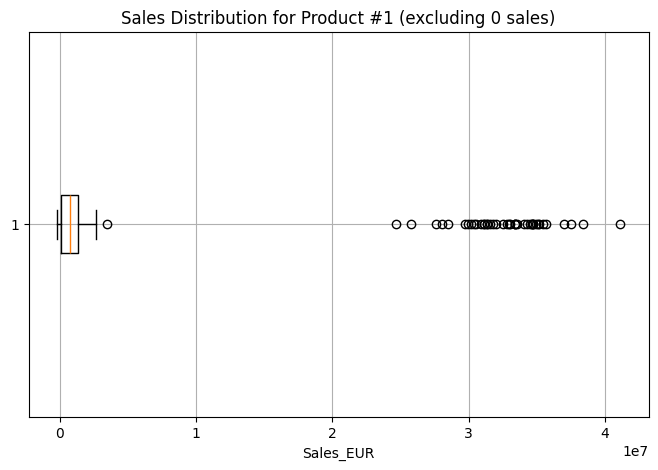

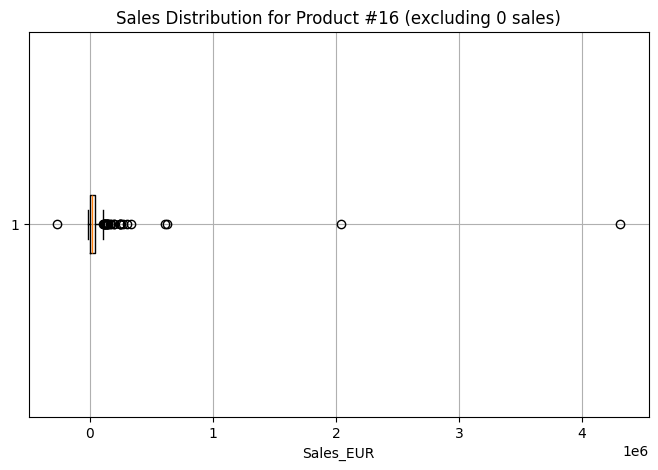

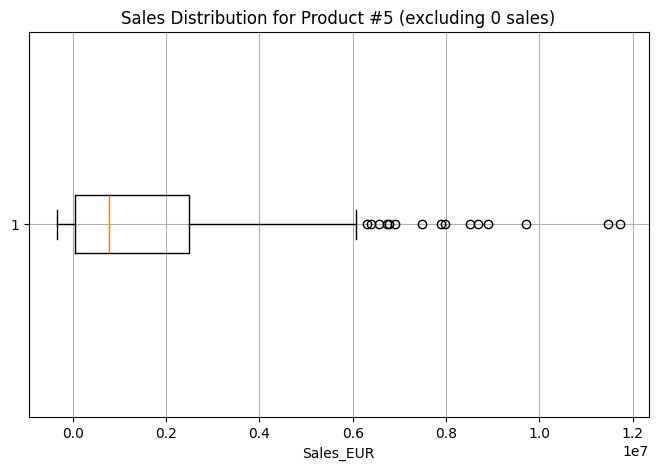

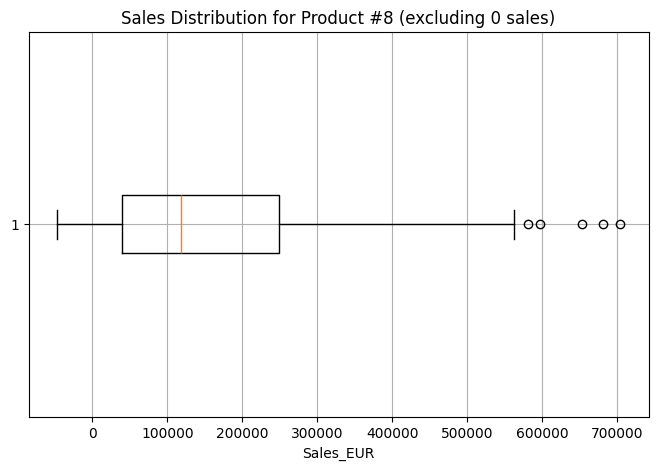

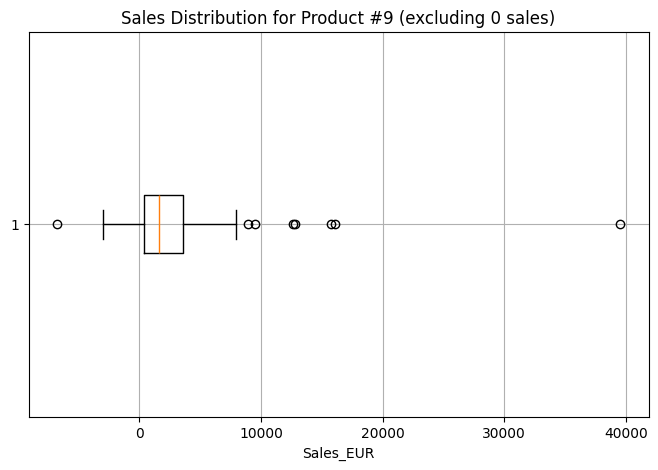

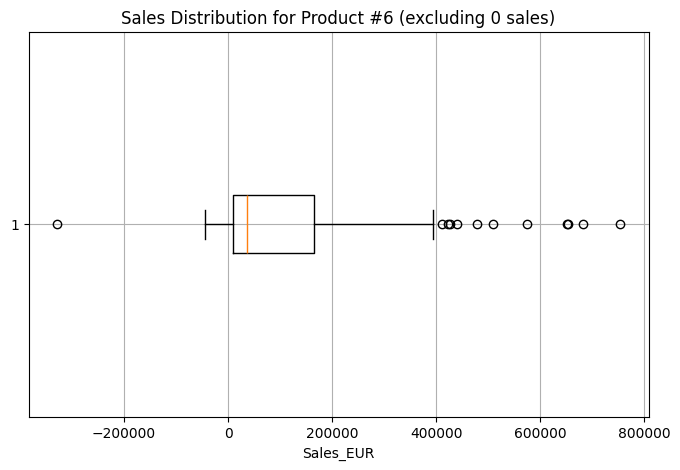

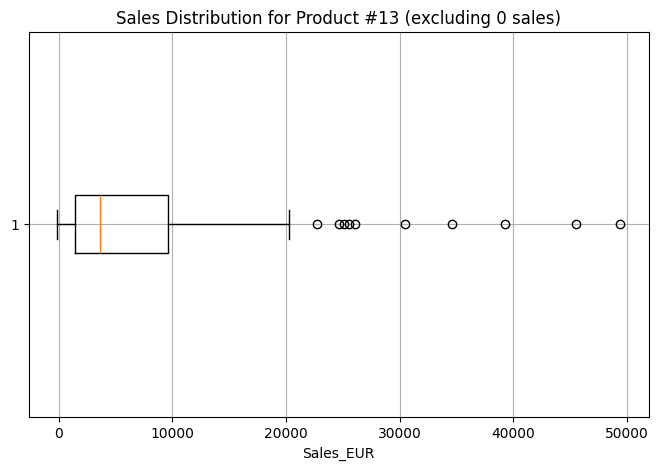

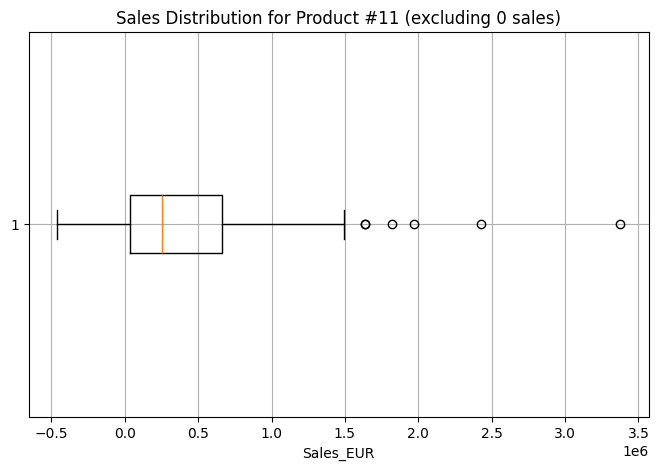

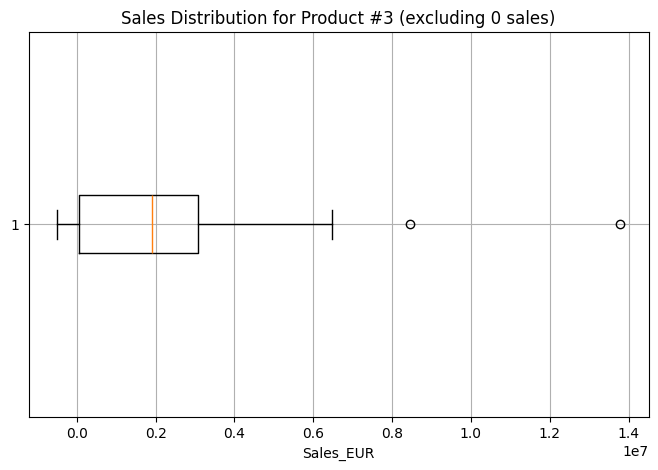

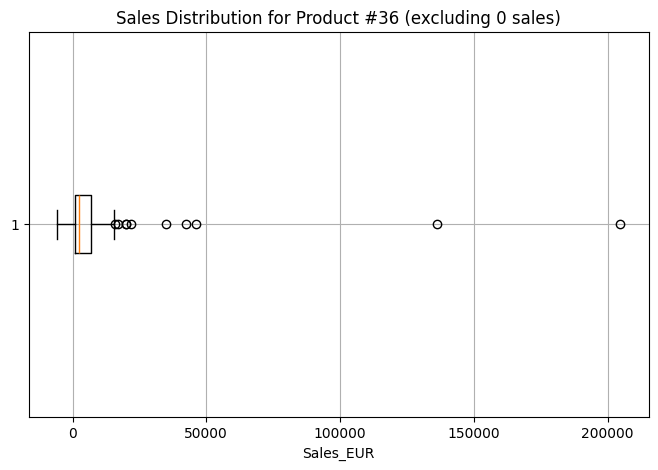

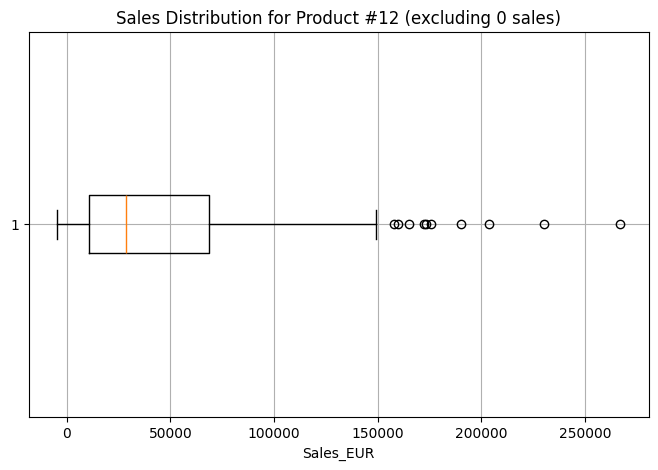

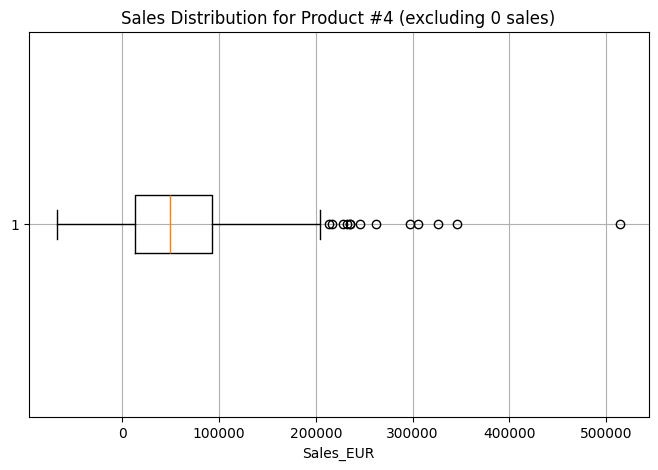

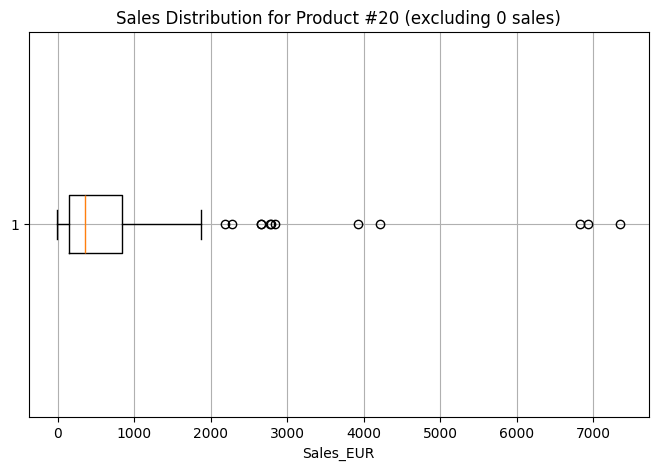

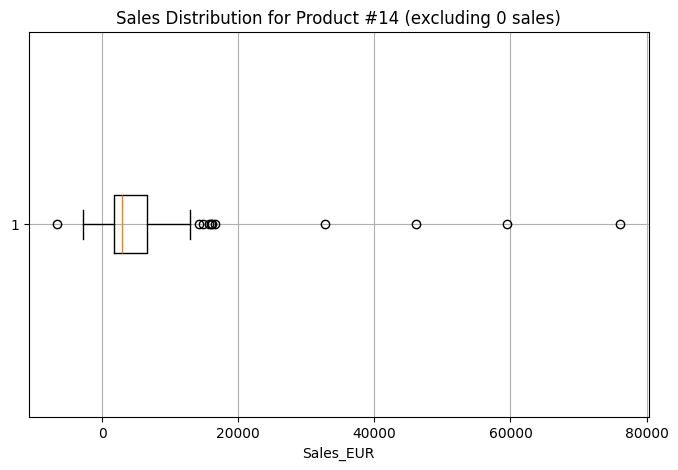

In [383]:
filtered_sales = sales_data[sales_data["Sales_EUR"] != 0]

unique_products = filtered_sales["Mapped_GCK"].unique()

for product in unique_products:
    product_data = filtered_sales[filtered_sales["Mapped_GCK"] == product]["Sales_EUR"]
    
    plt.figure(figsize=(8, 5))
    plt.boxplot(product_data, vert=False)
    plt.title(f"Sales Distribution for Product {product} (excluding 0 sales)")
    plt.xlabel("Sales_EUR")
    plt.grid(True)
    plt.show()


Check for Duplicate Dates and Their Frequencies

In [387]:
sales_data["DATE"] = pd.to_datetime(sales_data["DATE"], format="%d.%m.%Y")

duplicate_dates = sales_data["DATE"].duplicated().sum()
date_counts = sales_data["DATE"].value_counts().sort_index()

print(f"Number of duplicate dates: {duplicate_dates}")
print("\nFirst 10 occurrences of dates:")
print(date_counts.head(10))

Number of duplicate dates: 8586

First 10 occurrences of dates:
DATE
2018-10-01     9
2018-10-02    10
2018-10-03     1
2018-10-04     6
2018-10-05     8
2018-10-06     1
2018-10-08     7
2018-10-09     9
2018-10-10    10
2018-10-11     8
Name: count, dtype: int64


Quantity of Different Products

In [385]:
unique_values = sales_data["Mapped_GCK"].unique()

num_unique_values = len(unique_values)

print(f"Number of unique values in Mapped_GCK: {num_unique_values}")
print("Unique values:")
print(unique_values)

Number of unique values in Mapped_GCK: 14
Unique values:
['#1' '#11' '#6' '#8' '#12' '#16' '#4' '#5' '#3' '#9' '#14' '#13' '#20'
 '#36']


Distribution of Values by Product

In [386]:
mapped_gck_counts = sales_data["Mapped_GCK"].value_counts()
print("Count of each unique value in Mapped_GCK:")
print(mapped_gck_counts)

total_rows = len(sales_data)
print(f"\nTotal number of rows in the dataset: {total_rows}")

Count of each unique value in Mapped_GCK:
Mapped_GCK
#1     1179
#3     1017
#5      959
#8      944
#4      877
#12     803
#6      794
#16     765
#11     732
#13     441
#36     434
#9      333
#20     293
#14     231
Name: count, dtype: int64

Total number of rows in the dataset: 9802


Check for Duplicates 

In [388]:
duplicates_by_gck = sales_data.groupby("Mapped_GCK")["DATE"].apply(lambda x: x.duplicated().sum())

print("Duplicate DATEs per Mapped_GCK:")
print(duplicates_by_gck)

Duplicate DATEs per Mapped_GCK:
Mapped_GCK
#1     0
#11    0
#12    0
#13    0
#14    0
#16    0
#20    0
#3     0
#36    0
#4     0
#5     0
#6     0
#8     0
#9     0
Name: DATE, dtype: int64


Analyze Average Sales by Weekday, Month, and Year

In [389]:
sales_data["Weekday"] = sales_data["DATE"].dt.day_name()
sales_data["Year"] = sales_data["DATE"].dt.year
sales_data["Month"] = sales_data["DATE"].dt.month
weekday_sales = sales_data.groupby("Weekday")["Sales_EUR"].mean().sort_values()
month_sales = sales_data.groupby("Month")["Sales_EUR"].mean().sort_values()
year_sales = sales_data.groupby("Year")["Sales_EUR"].mean().sort_values()


In [390]:
print(weekday_sales)

Weekday
Saturday     173832.675192
Sunday       191665.814371
Tuesday      200995.492794
Wednesday    212515.561120
Thursday     221827.190011
Monday       347070.474352
Friday       403934.651971
Name: Sales_EUR, dtype: float64


In [391]:
print(month_sales)

Month
1     223989.702222
11    243629.551351
7     254406.813097
10    259941.360515
3     273163.379773
5     273221.225225
6     282490.542569
2     285487.939220
8     288530.137681
4     293675.887078
12    297922.155529
9     311129.041892
Name: Sales_EUR, dtype: float64


In [392]:
print(year_sales)

Year
2018    221508.560250
2020    265281.977690
2019    277406.693069
2021    279945.056481
2022    296520.236872
Name: Sales_EUR, dtype: float64


Visualize Average Sales per Product

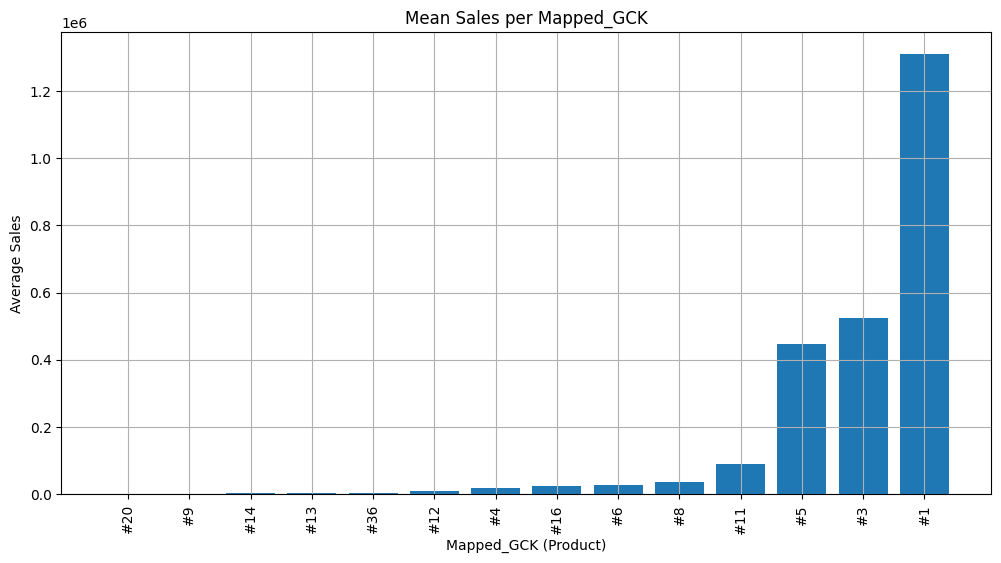

In [393]:
mapped_gck_means = sales_data.groupby("Mapped_GCK")["Sales_EUR"].mean().sort_values()

plt.figure(figsize=(12, 6))
plt.bar(mapped_gck_means.index, mapped_gck_means.values)
plt.xticks(rotation=90)
plt.xlabel("Mapped_GCK (Product)")
plt.ylabel("Average Sales")
plt.title("Mean Sales per Mapped_GCK")
plt.grid(True)
plt.show()

Mean Sales per Product

In [394]:
mapped_gck_means = sales_data.groupby("Mapped_GCK")["Sales_EUR"].mean().sort_values()

# Display the values
print("Mean Sales per Product:")
print(mapped_gck_means)


Mean Sales per Product:
Mapped_GCK
#20    2.672628e+02
#9     9.262072e+02
#14    2.137714e+03
#13    2.288236e+03
#36    2.300864e+03
#12    1.031065e+04
#4     1.781884e+04
#16    2.404064e+04
#6     2.599726e+04
#8     3.693975e+04
#11    9.002908e+04
#5     4.479615e+05
#3     5.245265e+05
#1     1.309759e+06
Name: Sales_EUR, dtype: float64


Check the Sales_Data

In [343]:
sales_data.head(5)

,DATE,Mapped_GCK,Sales_EUR,Weekday,Year,Month
0,2018-10-01,#1,0,Monday,2018,10
1,2018-10-02,#1,0,Tuesday,2018,10
2,2018-10-03,#1,0,Wednesday,2018,10
3,2018-10-04,#1,0,Thursday,2018,10
4,2018-10-05,#1,0,Friday,2018,10


### 4. Market Data Analysis

 Preview first rows of Market Data

In [397]:
market_data.head(5)

,Date,China - Production Index Machinery & Electricals,China - Shipments Index Machinery & Electricals,France - Production Index Machinery & Electricals,France - Shipments Index Machinery & Electricals,Germany - Production Index Machinery & Electricals,Germany - Shipments Index Machinery & Electricals,Italy - Production Index Machinery & Electricals,Italy - Shipments Index Machinery & Electricals,Japan - Production Index Machinery & Electricals,Japan - Shipments Index Machinery & Electricals,Switzerland - Production Index Machinery & Electricals,Switzerland - Shipments Index Machinery & Electricals,United Kingdom - Production Index Machinery & Electricals,United Kingdom - Shipments Index Machinery & Electricals,United States - Production Index Machinery & Electricals,United States - Shipments Index Machinery & Electricals,Europe - Production Index Machinery & Electricals,Europe - Shipments Index Machinery & Electricals,World: Price of Base Metals,World: Price of Energy,World: Price of Metals & Minerals,World: Price of Natural gas index,"World: Price of Crude oil, average",World: Price of Copper,United States: EUR in LCU,Producer Prices - United States: Electrical equipment,Producer Prices - United Kingdom: Electrical equipment,Producer Prices - Italy: Electrical equipment,Producer Prices - France: Electrical equipment,Producer Prices - Germany: Electrical equipment,Producer Prices - China: Electrical equipment,production index - United States: Machinery and equipment n.e.c.,production index - World: Machinery and equipment n.e.c.,production index - Switzerland: Machinery and equipment n.e.c.,production index - United Kingdom: Machinery and equipment n.e.c.,production index - Italy: Machinery and equipment n.e.c.,production index - Japan: Machinery and equipment n.e.c.,production index - France: Machinery and equipment n.e.c.,production index - Germany: Machinery and equipment n.e.c.,production index - United States: Electrical equipment,production index - World: Electrical equipment,production index - Switzerland: Electrical equipment,production index - United Kingdom: Electrical equipment,production index - Italy: Electrical equipment,production index - Japan: Electrical equipment,production index - France: Electrical equipment,production index - Germany: Electrical equipment
0,2004m2,16.940704,16.940704,112.091273,83.458866,82.623037,79.452532,124.289603,86.560493,109.33401,110.495272,91.221862,89.987275,111.353812,73.601265,107.6014,79.24023,97.122911,80.09853,54.039811,44.123338,48.747945,87.076974,39.639458,36.623832,1.2646,78.969864,80.757423,93.020027,NaN,93.230453,NaN,102.491722,97.597374,97.1,106.191977,116.790276,110.890034,118.274109,80.82901,117.723991,NaN,81.1,120.706516,141.510864,106.161262,102.077057,85.9132
1,2004m3,23.711852,23.711852,136.327976,106.168192,100.556582,97.012918,143.411662,106.344544,140.884616,144.686166,85.866287,79.883583,127.558608,84.047595,110.187364,98.619024,113.783904,96.015929,54.666162,47.588957,49.256157,87.192705,42.592034,39.931055,1.2262,79.673569,80.962135,93.540268,NaN,93.335678,NaN,105.62748,113.224892,91.195116,121.625075,139.288391,141.176853,148.121841,102.130104,119.220779,NaN,76.690307,138.30955,152.880234,140.288741,117.225685,97.670815
2,2004m4,24.435235,24.435235,117.791806,92.007646,89.653203,84.932358,129.083828,95.579673,105.853579,102.655769,85.622508,79.740802,108.732297,73.026027,108.166564,89.774031,101.715199,85.167236,54.872715,47.779013,49.423751,91.379923,42.650637,39.134854,1.1985,80.337639,80.757423,93.852425,NaN,93.440903,NaN,103.484955,100.16909,93.793535,104.965505,125.289566,105.648765,125.482231,90.961426,117.441124,NaN,71.552403,115.55733,137.796875,106.271197,105.335777,87.253983
3,2004m5,23.708115,23.708115,109.002541,85.696486,86.880571,82.372794,135.590391,100.087039,101.864777,100.305285,85.378729,79.598021,110.6452,74.591883,108.425887,87.463813,101.275727,84.485767,51.230356,53.590898,46.468392,99.04452,47.517121,36.278433,1.2007,80.798828,80.

Clean and Reformat Market Data Header

In [396]:
market_data = market_data.drop(index=2).reset_index(drop=True)

new_columns = [
    f"{market_data.iloc[0, i]} - {market_data.iloc[1, i]}" if pd.notna(market_data.iloc[0, i]) 
    else market_data.iloc[1, i] 
    for i in range(market_data.shape[1])
]

market_data.columns = new_columns
market_data = market_data.iloc[2:].reset_index(drop=True)

market_data = market_data.rename(columns={market_data.columns[0]: "Date"})

Extract Year and Month from Date Column

In [398]:
market_data["Date"] = market_data["Date"].str.strip()

market_data["Year"] = market_data["Date"].str[:4].astype(int)
market_data["Month"] = market_data["Date"].str[5:].astype(int)

Validate Year and Month Extraction

In [400]:
year_counts = market_data["Year"].value_counts().sort_index()
month_counts = market_data["Month"].value_counts().sort_index()

print("Unique Years and Counts:")
print(year_counts)

print("\nUnique Months and Counts:")
print(month_counts)


Unique Years and Counts:
Year
2004    11
2005    12
2006    12
2007    12
2008    12
2009    12
2010    12
2011    12
2012    12
2013    12
2014    12
2015    12
2016    12
2017    12
2018    12
2019    12
2020    12
2021    12
2022     4
Name: count, dtype: int64

Unique Months and Counts:
Month
1     18
2     19
3     19
4     19
5     18
6     18
7     18
8     18
9     18
10    18
11    18
12    18
Name: count, dtype: int64


### 5. Feature Selection

#### Selection of Key Macroeconomic Variables

Based on our analysis and discretion, we believe that the following variables are the most important for predicting Siemens' monthly sales . These variables were selected to balance **demand-side factors, cost influences, and production constraints**, while following the expert advice of using **fewer but high-value features**.

#### **Production and Shipment Indices**

- **China - Production Index Machinery & Electricals**  and **United States - Production Index Machinery & Electricals**  
   Measures industrial production in Siemens’ key client countries. Higher values may reflect increased domestic demand for Siemens-related goods.

- **China - Shipments Index Machinery & Electricals** and **United States - Shipments Index Machinery & Electricals**  
   Tracks shipment volumes in the machinery and electrical sector. Growth suggests stronger export performance and external demand.

- **Germany - Production Index Machinery & Electricals** and **Germany - Shipments Index Machinery & Electricals**  
   Reflect local industrial and distribution activity. Especially relevant as the sales data comes from a German branch.


#### **Producer Prices (Cost of Siemens' Industrial Goods)**

- **Producer Prices - United States: Electrical Equipment**  
   Reflects how costly electrical equipment is for Siemens’ U.S.-based clients. Higher prices may reduce purchasing power; lower prices could support demand.

- **Producer Prices - China: Electrical Equipment**  
   Indicates equipment costs in China, potentially affecting Siemens’ production expenses and pricing strategies.

- **Producer Prices - Germany: Electrical Equipment**  
   Relevant to local operations. Fluctuations in German producer prices may influence both profitability and sales performance, since data is from a German branch.


#### **Raw Material and Energy Costs**
- **World: Price of Base Metals**  
   Siemens’ industrial products depend on metals like steel and aluminum. Higher prices increase production costs.

- **World: Price of Energy**  
   Rising energy costs elevate manufacturing expenses, potentially influencing Siemens’ pricing strategies.

- **World: Price of Crude Oil, Average**  
   Affects transportation and supply chain costs. Significant increases may reduce industrial investment and weigh on Siemens’ sales.

- **World: Price of Copper**  
   A key input in electrical equipment manufacturing.

These selected variables cover both **demand-side** factors (production and shipments), **cost structures** (producer prices), and **macro-level influences** (raw material and energy prices). This approach ensures a balanced, minimal, and high-impact feature selection.


Correlation Analysis of Selected Macroeconomic Features

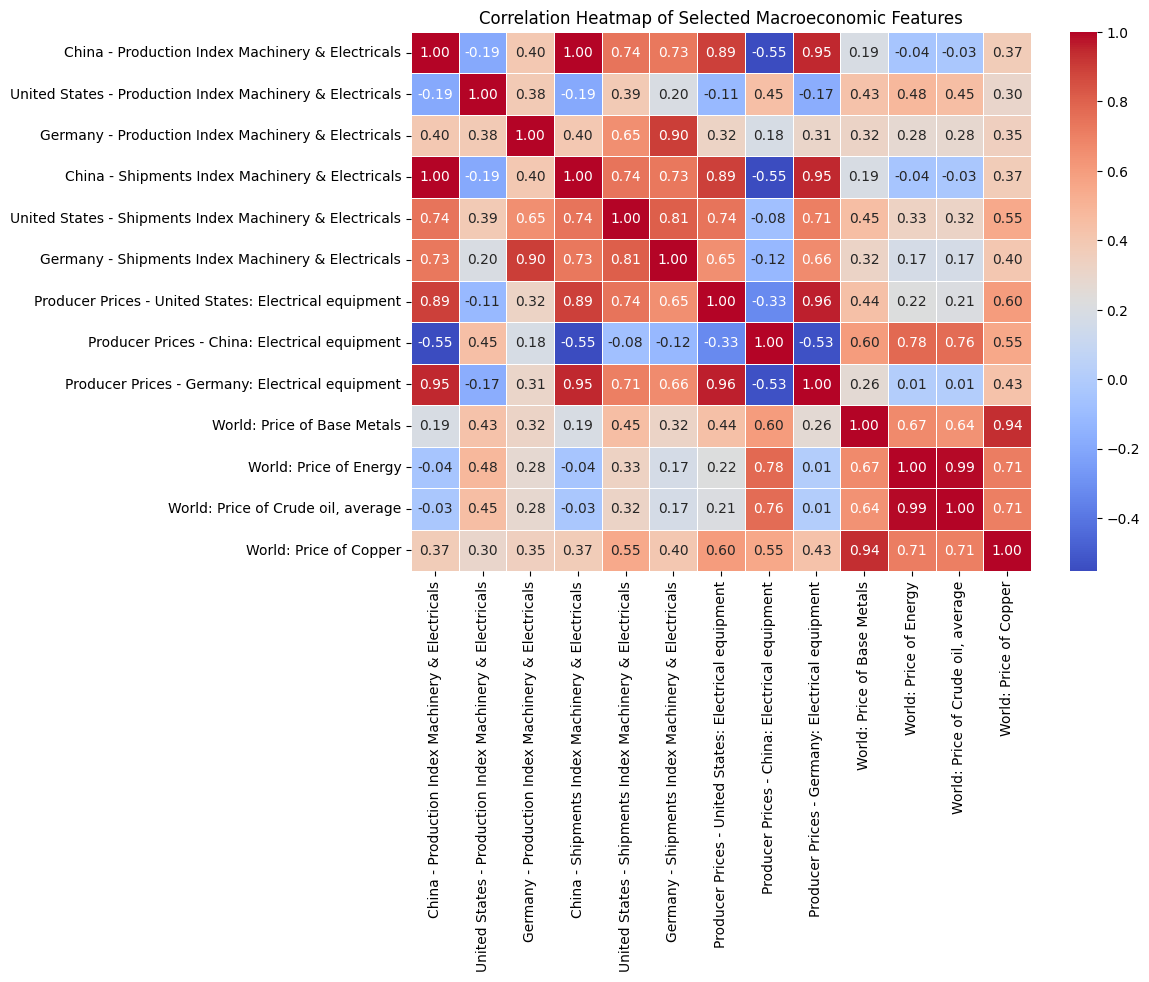

In [401]:
macro_features = [
    "China - Production Index Machinery & Electricals",
    "United States - Production Index Machinery & Electricals",
    "Germany - Production Index Machinery & Electricals",
    "China - Shipments Index Machinery & Electricals",
    "United States - Shipments Index Machinery & Electricals",
    "Germany - Shipments Index Machinery & Electricals",
    "Producer Prices - United States: Electrical equipment",
    "Producer Prices - China: Electrical equipment",
    "Producer Prices - Germany: Electrical equipment",
    "World: Price of Base Metals",
    "World: Price of Energy",
    "World: Price of Crude oil, average",
    "World: Price of Copper"
]

correlation_matrix = market_data[macro_features].corr()

plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Selected Macroeconomic Features")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

### Feature Selection Strategy

#### **Consolidating Redundant Features**
##### **China - Production Index Machinery & Electricals**
This variable exhibits **very high correlation** with multiple other features:
- **1.00** with `China - Shipments Index Machinery & Electricals`
- **0.74** with `United States - Shipments Index Machinery & Electricals`
- **0.73** with `Germany - Shipments Index Machinery & Electricals`
- **0.89** with `Producer Prices - United States: Electrical Equipment`
- **0.95** with `Producer Prices - Germany: Electrical Equipment`

Given this extreme correlation, we will **retain "China - Production Index Machinery & Electricals" as a representative variable**, allowing it to encapsulate the information from these **six** highly correlated features. 


##### **Aggregating World Price Features**
- **World: Price of Base Metals**  
- **World: Price of Energy**  
- **World: Price of Crude Oil, Average**  
- **World: Price of Copper**  

Our decision to merge these indicators was based on their **high correlation** and to to preserve shared economic influence while reducing redundancy.


#### **Removing Weakly Correlated Features**
The remaining three features:
- **Producer Prices - China: Electrical Equipment**
- **United States - Production Index Machinery & Electricals**
- **Germany - Production Index Machinery & Electricals**

show some moderate correlations. Their effects will already be reflected in the merged features, so we **exclude them** to keep the model clean and efficient.



Aggregaten the  World Price Features

In [350]:
market_data["Key_Materials_Price_Index"] = (
    market_data["World: Price of Base Metals"] +
    market_data["World: Price of Energy"] +
    market_data["World: Price of Crude oil, average"] +
    market_data["World: Price of Copper"]
) / 4


### 6. Remove Outliers

In [ ]:
monthly_sales_data = sales_data.groupby(["Mapped_GCK", "Year", "Month"])["Sales_EUR"].sum().reset_index()

print(monthly_sales_data.head())

  Mapped_GCK  Year  Month  Sales_EUR
0         #1  2018     10   36098918
1         #1  2018     11    5140757
2         #1  2018     12   37889610
3         #1  2019      1   27728146
4         #1  2019      2   34793162


In [352]:
print(monthly_sales_data)

    Mapped_GCK  Year  Month  Sales_EUR
0           #1  2018     10   36098918
1           #1  2018     11    5140757
2           #1  2018     12   37889610
3           #1  2019      1   27728146
4           #1  2019      2   34793162
..         ...   ...    ...        ...
597         #9  2021     12      14935
598         #9  2022      1       2065
599         #9  2022      2        902
600         #9  2022      3       4452
601         #9  2022      4       3285

[602 rows x 4 columns]


In [ ]:
# Define a small epsilon to shift all values above zero
epsilon = abs(monthly_sales_data["Sales_EUR"].min()) + 1  # Ensures all values are positive

# Apply log transformation
monthly_sales_data["Sales_EUR_Log"] = np.log1p(monthly_sales_data["Sales_EUR"] + epsilon)

# Display the updated dataframe
monthly_sales_data.head()


,Mapped_GCK,Year,Month,Sales_EUR,Sales_EUR_Log
0,#1,2018,10,36098918,17.402195
1,#1,2018,11,5140757,15.455664
2,#1,2018,12,37889610,17.450589
3,#1,2019,1,27728146,17.138507
4,#1,2019,2,34793162,17.365368


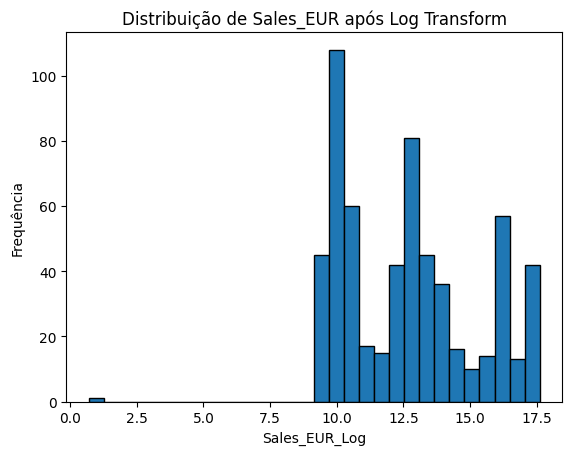

In [367]:
import matplotlib.pyplot as plt

plt.hist(monthly_sales_data["Sales_EUR_Log"], bins=30, edgecolor="black")
plt.title("Distribuição de Sales_EUR após Log Transform")
plt.xlabel("Sales_EUR_Log")
plt.ylabel("Frequência")
plt.show()

In [368]:
print(monthly_sales_data["Sales_EUR_Log"].describe())

count    602.000000
mean      12.679792
std        2.544255
min        0.693147
25%       10.273826
50%       12.632573
75%       14.289678
max       17.610960
Name: Sales_EUR_Log, dtype: float64


In [369]:
from scipy.stats import boxcox

# Ensure Sales_EUR is positive
monthly_sales_data["Sales_EUR_Shifted"] = monthly_sales_data["Sales_EUR"] + abs(monthly_sales_data["Sales_EUR"].min()) + 1

# Apply Box-Cox transformation
monthly_sales_data["Sales_EUR_BoxCox"], lambda_ = boxcox(monthly_sales_data["Sales_EUR_Shifted"])

print(f"Optimal Box-Cox Lambda: {lambda_}")

Optimal Box-Cox Lambda: -0.030455970218517068


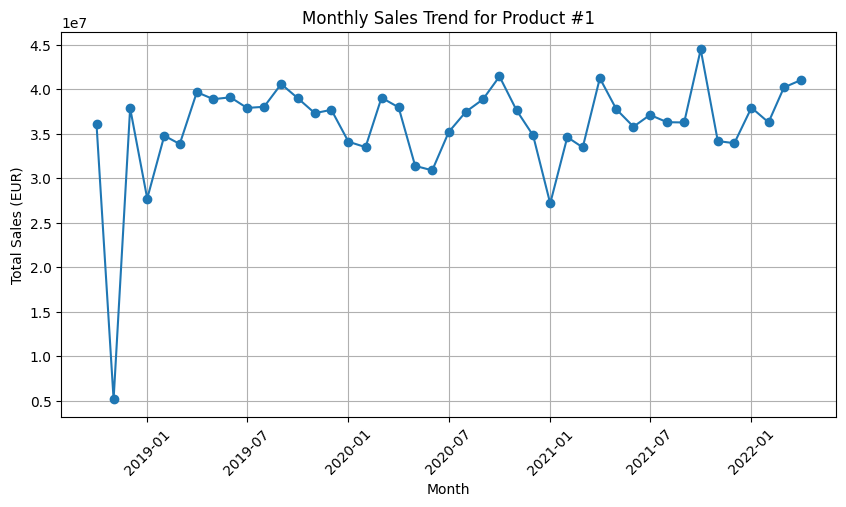

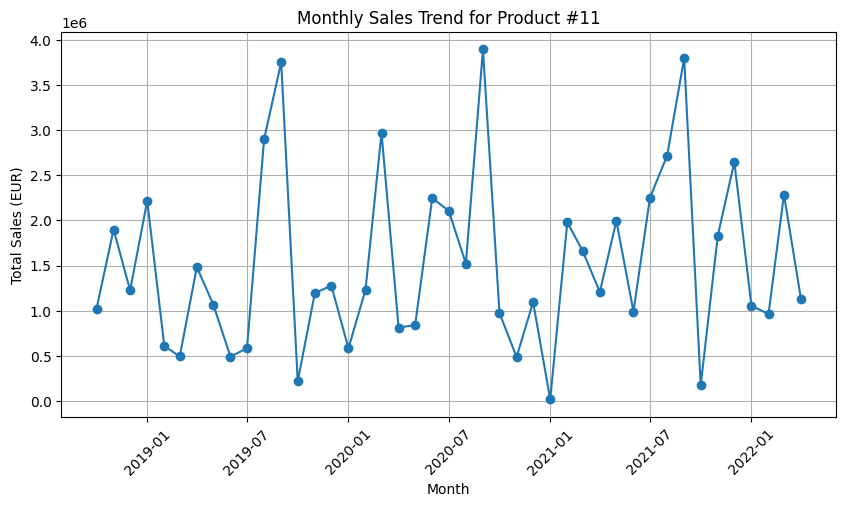

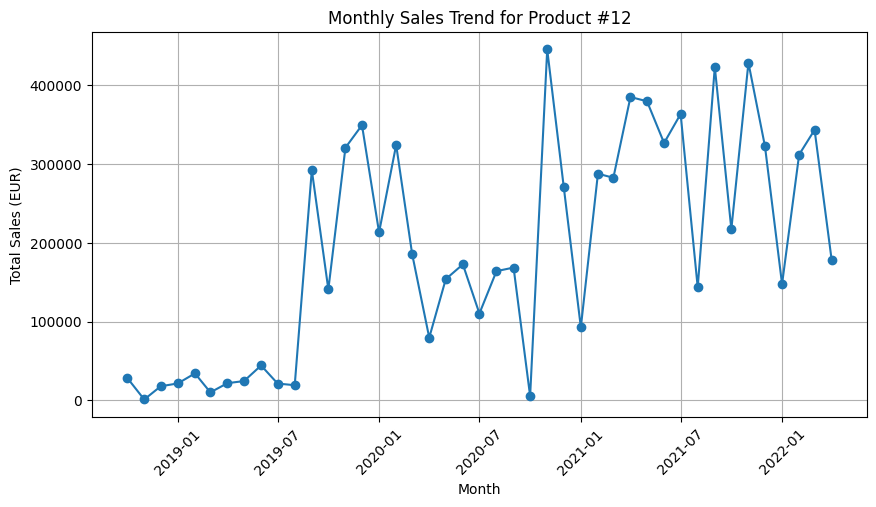

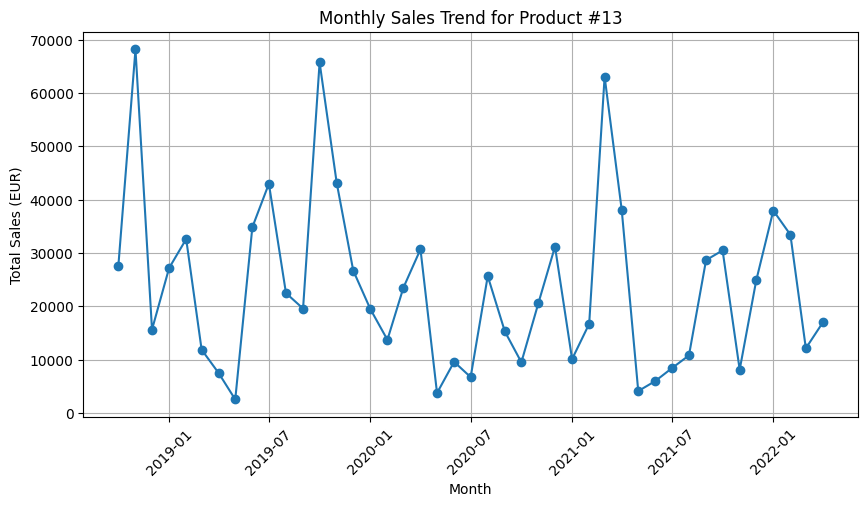

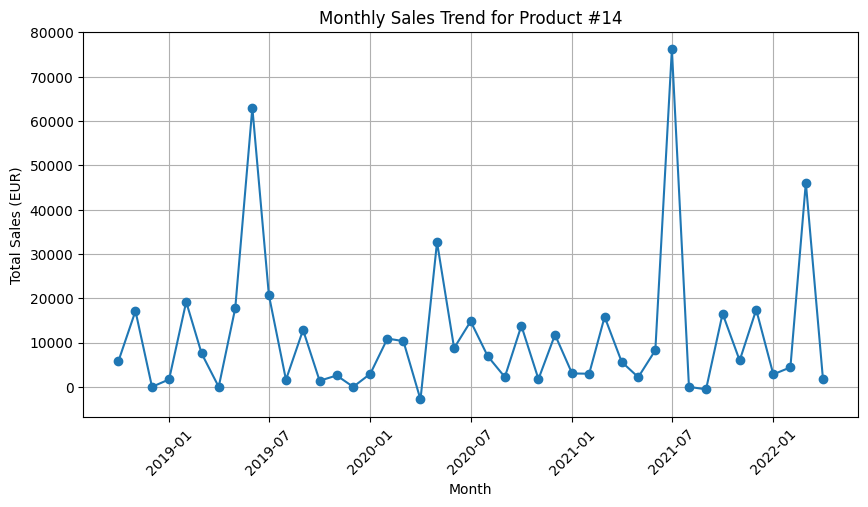

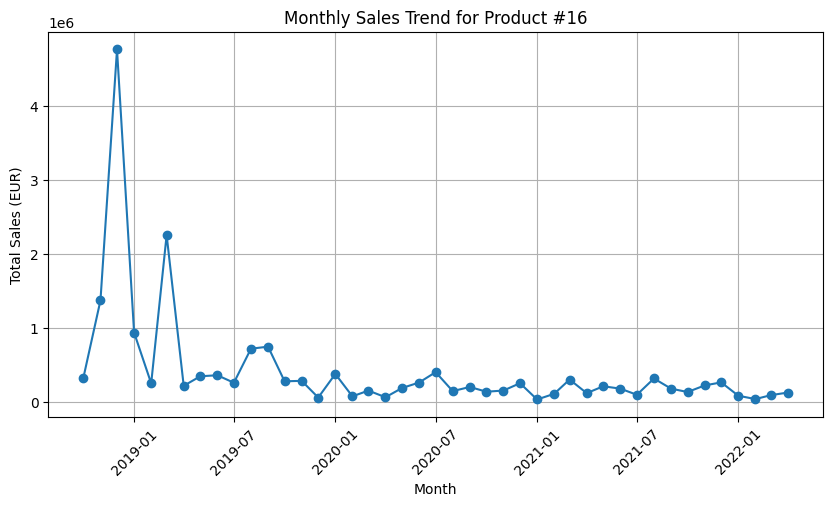

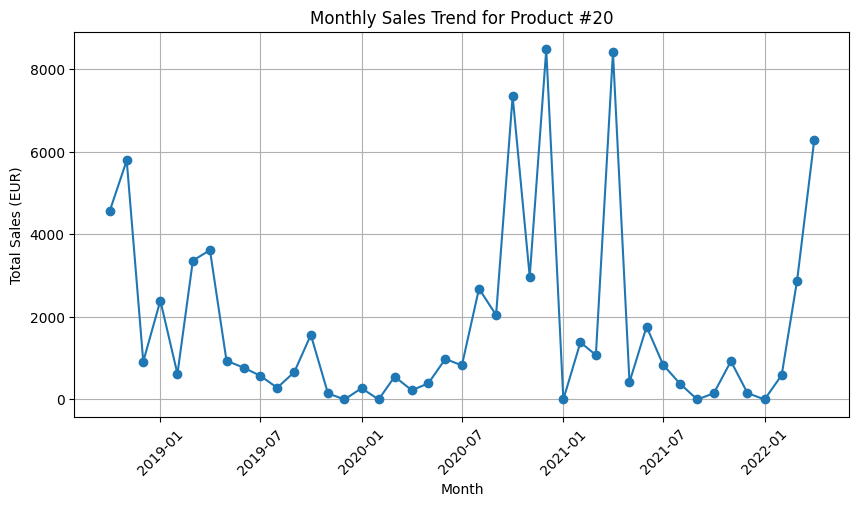

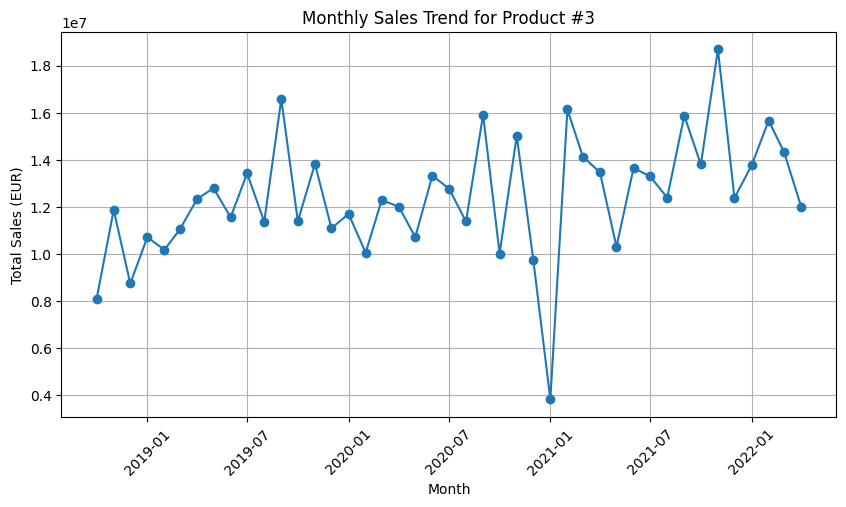

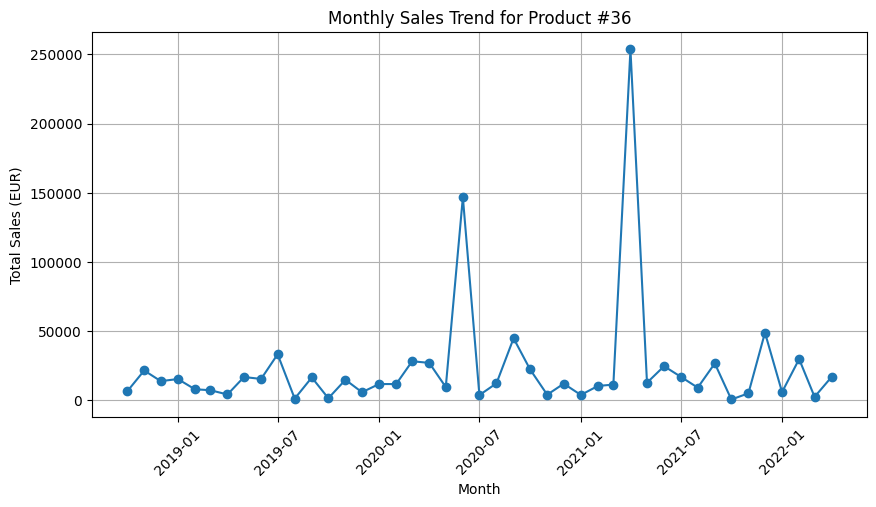

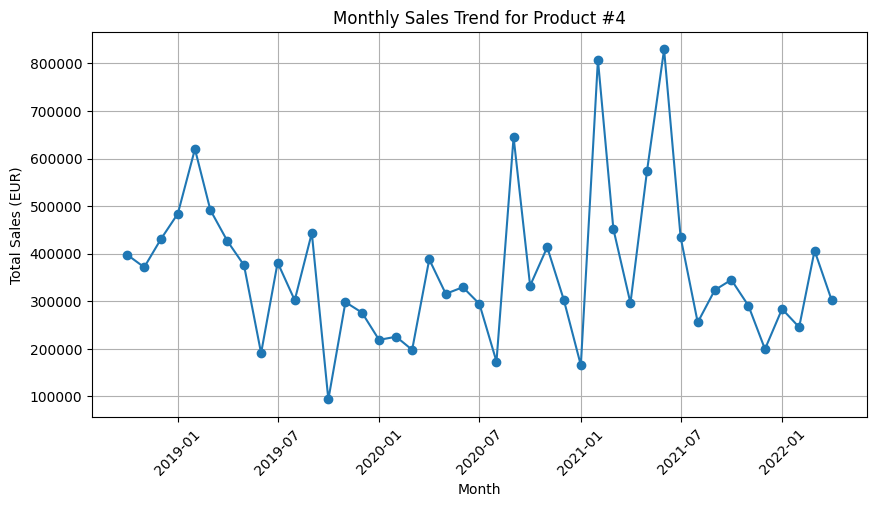

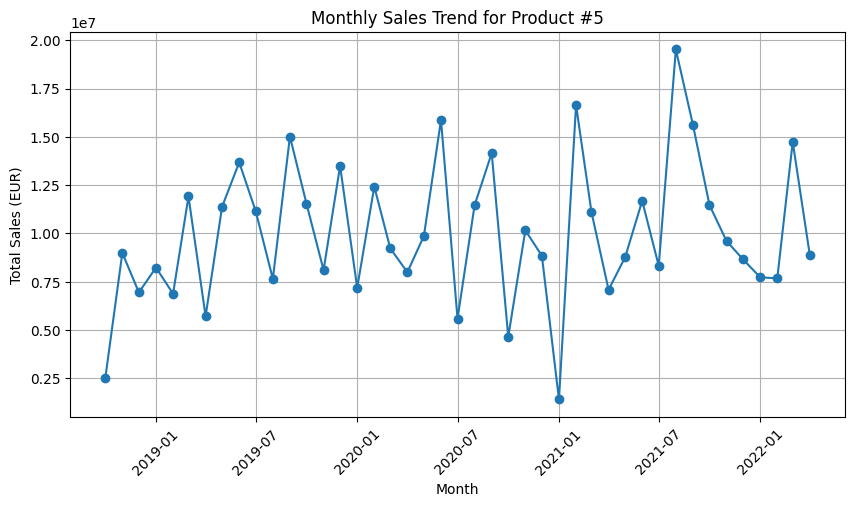

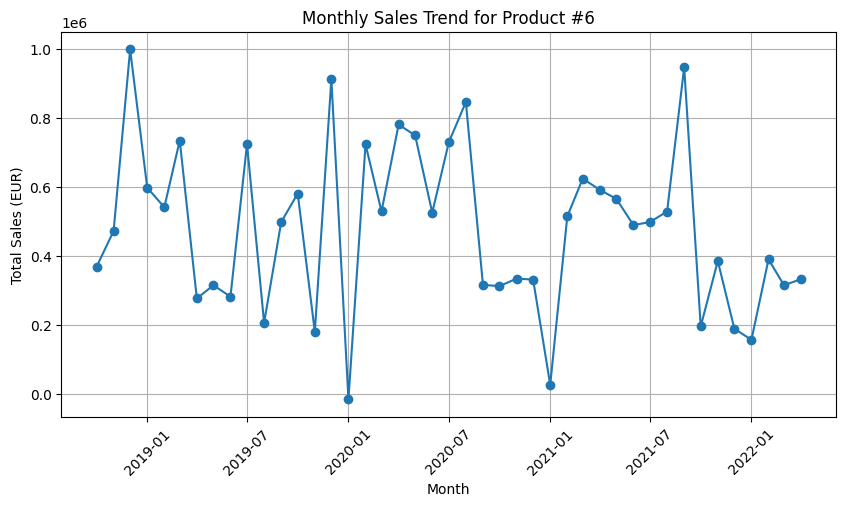

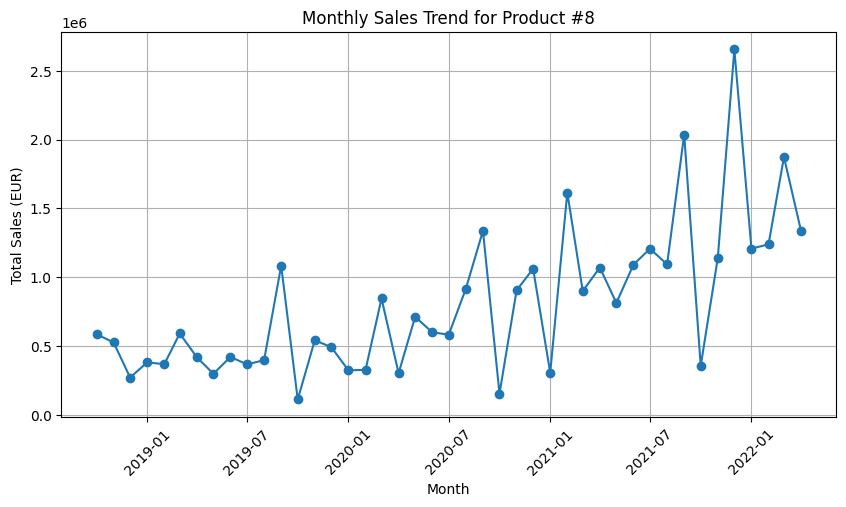

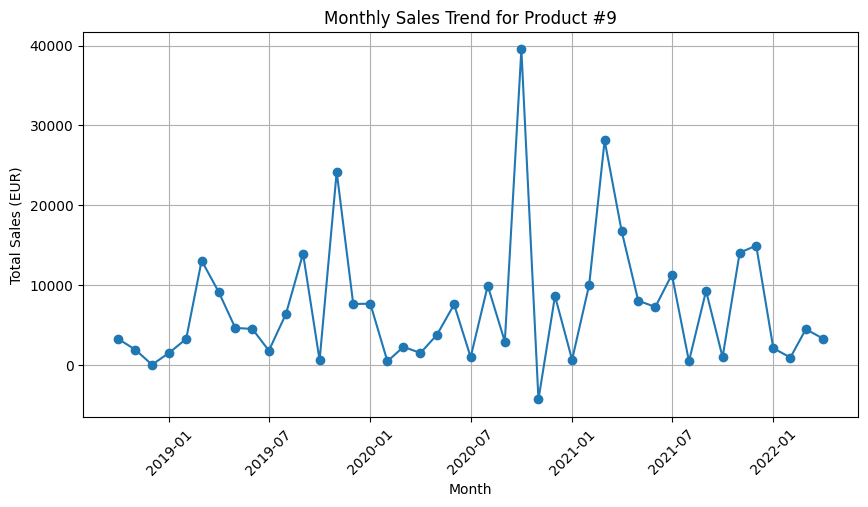

In [354]:
# Convert Year and Month into a datetime format for better plotting
monthly_sales_data["Date"] = pd.to_datetime(monthly_sales_data["Year"].astype(str) + "-" + monthly_sales_data["Month"].astype(str) + "-01")

# Get the unique products (Mapped_GCK)
unique_products = monthly_sales_data["Mapped_GCK"].unique()

# Generate a separate graph for each product
for product in unique_products:
    product_data = monthly_sales_data[monthly_sales_data["Mapped_GCK"] == product]
    
    plt.figure(figsize=(10, 5))
    plt.plot(product_data["Date"], product_data["Sales_EUR"], marker="o", linestyle="-")
    plt.title(f"Monthly Sales Trend for Product {product}")
    plt.xlabel("Month")
    plt.ylabel("Total Sales (EUR)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()
    

monthly_sales_data = monthly_sales_data.drop(columns=["Date"])


In [355]:
# Select only the required columns from market_data
market_selected = market_data[["Year", "Month", "Key_Materials_Price_Index", "China - Production Index Machinery & Electricals"]]

# Merge the datasets on Year and Month
merged_data = monthly_sales_data.merge(market_selected, on=["Year", "Month"], how="left")

# Display the merged dataset
print(merged_data.head())  # Show the first few rows


  Mapped_GCK  Year  Month  Sales_EUR  Sales_EUR_Log Key_Materials_Price_Index  \
0         #1  2018     10   36098918      17.402195                 91.485525   
1         #1  2018     11    5140757      15.455664                 82.337572   
2         #1  2018     12   37889610      17.450589                 76.632765   
3         #1  2019      1   27728146      17.138507                 76.966467   
4         #1  2019      2   34793162      17.365368                 81.432649   

  China - Production Index Machinery & Electricals  
0                                       211.955755  
1                                       220.519655  
2                                       241.846854  
3                                       175.668147  
4                                       175.668147  


In [356]:
merged_data.rename(columns={
    "China - Production Index Machinery & Electricals": "Global_Industrial_Activity_Index"
}, inplace=True)

In [357]:
# Remove spaces and "#" from Mapped_GCK, converting it into a clean numerical format
merged_data["Mapped_GCK"] = merged_data["Mapped_GCK"].str.replace("#", "").str.strip()

# Convert Mapped_GCK to integer type (if applicable)
merged_data["Mapped_GCK"] = merged_data["Mapped_GCK"].astype(int)

In [358]:
merged_data.head(5)

,Mapped_GCK,Year,Month,Sales_EUR,Sales_EUR_Log,Key_Materials_Price_Index,Global_Industrial_Activity_Index
0,1,2018,10,36098918,17.402195,91.485525,211.955755
1,1,2018,11,5140757,15.455664,82.337572,220.519655
2,1,2018,12,37889610,17.450589,76.632765,241.846854
3,1,2019,1,27728146,17.138507,76.966467,175.668147
4,1,2019,2,34793162,17.365368,81.432649,175.668147


### 5. Modelling

In [359]:
import pandas as pd
from sklearn.metrics import mean_squared_error

ACCEPTABLE_PERCENTAGE = 15  

# Compute the RMSE threshold for each product
rmse_thresholds = []

for product_id in train_data["Mapped_GCK"].unique():
    mean_sales = train_data[train_data["Mapped_GCK"] == product_id]["Sales_EUR"].mean()
    threshold = (ACCEPTABLE_PERCENTAGE / 100) * mean_sales  # Fixed threshold
    rmse_thresholds.append([product_id, int(threshold)])  # Convert to full integer

# Convert to DataFrame for better visualization
rmse_threshold_df = pd.DataFrame(rmse_thresholds, columns=["Mapped_GCK", "RMSE_Threshold"])

# Display the DataFrame with full numbers
rmse_threshold_df


,Mapped_GCK,RMSE_Threshold
0,1,5313415
1,11,222956
2,12,25310
3,13,3498
4,14,1711
5,16,74422
6,20,295
7,3,1784927
8,36,3760
9,4,57248


In [360]:
from sklearn.model_selection import TimeSeriesSplit

# Sort data by Year and Month to ensure correct time-based ordering
merged_data = merged_data.sort_values(by=["Year", "Month"])

# Define the split point (80% train, 20% test)
split_point = int(len(merged_data) * 0.8)

# Split the dataset
train_data = merged_data.iloc[:split_point]
test_data = merged_data.iloc[split_point:]

# Display the sizes of each split
print(f"Train set size: {len(train_data)} rows")
print(f"Test set size: {len(test_data)} rows")


Train set size: 481 rows
Test set size: 121 rows


In [363]:
from prophet import Prophet
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# 1️⃣ Function to train Prophet with normalization
def train_prophet_for_product(mapped_gck):

    # Filter train data for the product
    product_train = train_data[train_data["Mapped_GCK"] == mapped_gck]

    if product_train.empty:
        print(f"No training data for Product {mapped_gck}, skipping...")
        return np.nan

    # Prepare data for Prophet
    prophet_df = product_train.rename(columns={"Sales_EUR_Log": "y"})
    prophet_df["ds"] = pd.to_datetime(prophet_df["Year"].astype(str) + "-" + prophet_df["Month"].astype(str) + "-01")
    prophet_df = prophet_df[["ds", "y"]]

    # Normalize 'y' (Sales_EUR) using MinMax Scaling
    scaler = MinMaxScaler()
    prophet_df["y"] = scaler.fit_transform(prophet_df[["y"]])  # Scale between 0 and 1

    # Train Prophet model
    model = Prophet()
    model.fit(prophet_df)

    # Filter test data for this product
    product_test = test_data[test_data["Mapped_GCK"] == mapped_gck].copy()

    if product_test.empty:
        print(f" No test data for Product {mapped_gck}, skipping...")
        return np.nan

    product_test["ds"] = pd.to_datetime(product_test["Year"].astype(str) + "-" + product_test["Month"].astype(str) + "-01")
    future = product_test[["ds"]].drop_duplicates()  # Ensure same test months

    # Forecast on scaled data
    forecast = model.predict(future)

    # Denormalize predictions back to original scale
    forecast["yhat"] = scaler.inverse_transform(forecast[["yhat"]])  # Convert back to Sales_EUR

    # Merge with actual test data
    merged_forecast = product_test.merge(forecast[["ds", "yhat"]], on="ds", how="left")

    # Drop NaNs before RMSE calculation
    merged_forecast = merged_forecast.dropna(subset=["Sales_EUR_Log", "yhat"])

    if merged_forecast.empty:
        print(f"No valid forecast data for RMSE calculation for Product {mapped_gck}")
        return np.nan

    # Calculate RMSE in the original scale
    rmse = np.sqrt(mean_squared_error(merged_forecast["Sales_EUR_Log"], merged_forecast["yhat"]))
    print(f"✅ Product {mapped_gck} - RMSE: {rmse}")

    return rmse

# 2️⃣ Run Prophet for each product in test data
valid_products = test_data["Mapped_GCK"].unique()
prophet_rmse_results = {gck: train_prophet_for_product(gck) for gck in valid_products}

# 3️⃣ Display final results
print("\n Final Prophet RMSE results:", prophet_rmse_results)


17:01:52 - cmdstanpy - INFO - Chain [1] start processing
17:01:52 - cmdstanpy - INFO - Chain [1] done processing
17:01:52 - cmdstanpy - INFO - Chain [1] start processing


✅ Product 16 - RMSE: 0.8761544703097697


17:01:53 - cmdstanpy - INFO - Chain [1] done processing
17:01:53 - cmdstanpy - INFO - Chain [1] start processing


✅ Product 20 - RMSE: 0.15495851121198023


17:01:53 - cmdstanpy - INFO - Chain [1] done processing
17:01:53 - cmdstanpy - INFO - Chain [1] start processing


✅ Product 3 - RMSE: 0.3009436650784007


17:01:53 - cmdstanpy - INFO - Chain [1] done processing
17:01:54 - cmdstanpy - INFO - Chain [1] start processing


✅ Product 36 - RMSE: 0.539563063938677


17:01:54 - cmdstanpy - INFO - Chain [1] done processing
17:01:54 - cmdstanpy - INFO - Chain [1] start processing


✅ Product 4 - RMSE: 0.41156979900681323


17:01:54 - cmdstanpy - INFO - Chain [1] done processing
17:01:55 - cmdstanpy - INFO - Chain [1] start processing


✅ Product 5 - RMSE: 0.5331206174876085


17:01:55 - cmdstanpy - INFO - Chain [1] done processing
17:01:55 - cmdstanpy - INFO - Chain [1] start processing


✅ Product 6 - RMSE: 1.041719742087829


17:01:55 - cmdstanpy - INFO - Chain [1] done processing
17:01:55 - cmdstanpy - INFO - Chain [1] start processing


✅ Product 8 - RMSE: 0.39330170005087983


17:01:56 - cmdstanpy - INFO - Chain [1] done processing
17:01:56 - cmdstanpy - INFO - Chain [1] start processing


✅ Product 9 - RMSE: 0.5340517435229889


17:01:56 - cmdstanpy - INFO - Chain [1] done processing
17:01:56 - cmdstanpy - INFO - Chain [1] start processing


✅ Product 1 - RMSE: 0.1731561512553578


17:01:56 - cmdstanpy - INFO - Chain [1] done processing
17:01:56 - cmdstanpy - INFO - Chain [1] start processing


✅ Product 11 - RMSE: 0.9618057747096318


17:01:57 - cmdstanpy - INFO - Chain [1] done processing
17:01:57 - cmdstanpy - INFO - Chain [1] start processing
17:01:57 - cmdstanpy - INFO - Chain [1] done processing


✅ Product 12 - RMSE: 0.9223969629731086


17:01:57 - cmdstanpy - INFO - Chain [1] start processing


✅ Product 13 - RMSE: 0.45031983864308645


17:01:57 - cmdstanpy - INFO - Chain [1] done processing


✅ Product 14 - RMSE: 0.45009847311682444

 Final Prophet RMSE results: {16: 0.8761544703097697, 20: 0.15495851121198023, 3: 0.3009436650784007, 36: 0.539563063938677, 4: 0.41156979900681323, 5: 0.5331206174876085, 6: 1.041719742087829, 8: 0.39330170005087983, 9: 0.5340517435229889, 1: 0.1731561512553578, 11: 0.9618057747096318, 12: 0.9223969629731086, 13: 0.45031983864308645, 14: 0.45009847311682444}


In [319]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore")  # Ignore warnings for cleaner output

# Step 1: Prepare the Data
def prepare_sarima_data(product_id):
    product_data = train_data[train_data["Mapped_GCK"] == product_id].copy()
    product_data["ds"] = pd.to_datetime(product_data["Year"].astype(str) + "-" + product_data["Month"].astype(str) + "-01")
    product_data = product_data.set_index("ds")["Sales_EUR"].asfreq("MS")  # Set to Monthly Start frequency
    return product_data

# Step 2: Train SARIMA Model
def train_sarima_for_product(product_id):
    print(f"🔄 Training SARIMA for Product {product_id}...")

    # Prepare data
    product_series = prepare_sarima_data(product_id)

    if product_series.isna().sum() > 0:
        print(f"⚠️ Product {product_id} has missing values! Filling with interpolation.")
        product_series = product_series.interpolate()

    # Step 3: Find the best SARIMA parameters
    best_aic = float("inf")
    best_order = None
    best_seasonal_order = None

    seasonal_period = 12  # Monthly seasonality

    # Try different combinations of (p, d, q) and (P, D, Q, s)
    for p in range(0, 3):
        for d in range(0, 2):
            for q in range(0, 3):
                for P in range(0, 3):
                    for D in range(0, 2):
                        for Q in range(0, 3):
                            try:
                                model = sm.tsa.statespace.SARIMAX(
                                    product_series,
                                    order=(p, d, q),
                                    seasonal_order=(P, D, Q, seasonal_period),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False,
                                )
                                result = model.fit(disp=False)
                                if result.aic < best_aic:
                                    best_aic = result.aic
                                    best_order = (p, d, q)
                                    best_seasonal_order = (P, D, Q, seasonal_period)
                            except:
                                continue

    print(f"✅ Best SARIMA order for Product {product_id}: {best_order}, {best_seasonal_order} (AIC={best_aic})")

    # Step 4: Fit the best SARIMA model
    best_model = sm.tsa.statespace.SARIMAX(
        product_series,
        order=best_order,
        seasonal_order=best_seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False,
    ).fit()

    # Step 5: Ensure "ds" column exists in test data
    test_product_data = test_data[test_data["Mapped_GCK"] == product_id].copy()
    
    if test_product_data.empty:
        print(f"⚠️ No test data for Product {product_id}, skipping...")
        return np.nan

    test_product_data["ds"] = pd.to_datetime(test_product_data["Year"].astype(str) + "-" + test_product_data["Month"].astype(str) + "-01")
    test_product_data = test_product_data.set_index("ds")  # Ensure "ds" is the index

    # Step 6: Forecast Future Sales
    forecast = best_model.get_forecast(steps=len(test_product_data))
    forecast_values = forecast.predicted_mean

    # Step 7: Merge forecasts with actual values
    merged_forecast = test_product_data[["Sales_EUR"]].copy()  # Ensure actual sales are present
    merged_forecast["Predicted"] = forecast_values

    # Drop NaNs before RMSE calculation
    merged_forecast = merged_forecast.dropna()

    if merged_forecast.empty:
        print(f"⚠️ No valid data for RMSE calculation for Product {product_id}")
        return np.nan

    # Step 8: Calculate RMSE
    rmse = np.sqrt(mean_squared_error(merged_forecast["Sales_EUR"], merged_forecast["Predicted"]))
    print(f"✅ Product {product_id} - SARIMA RMSE: {rmse}")

    return rmse

# Run SARIMA for Product #3
sarima_rmse_product3 = train_sarima_for_product(3)

print(f"📊 Final SARIMA RMSE for Product #3: {sarima_rmse_product3}")


🔄 Training SARIMA for Product 3...
✅ Best SARIMA order for Product 3: (0, 0, 0), (0, 1, 2, 12) (AIC=6.0)
✅ Product 3 - SARIMA RMSE: 3903198.9053713367
📊 Final SARIMA RMSE for Product #3: 3903198.9053713367
